# Testing Model Outputs
## Import Test Image

In [2]:
import os
import time
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [44]:
class Testing_Image():
    def __init__(self, root_dir: str, index: str):
        filename = index if index[-4:] == '.jpg' else index + ".jpg"
        self.path = os.path.join(root_dir, filename)
    
    def get_rgb(self, resize=True):
        img = cv2.imread(self.path)
        if resize:
            img = cv2.resize(img, (224, 224))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    def get_gray(self, resize=True):
        img = cv2.imread(self.path)
        if resize:
            img = cv2.resize(img, (224, 224))
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def get_lab(self, only_gray_layer=False, resize=True):
        img = cv2.imread(self.path)
        if resize:
            img = cv2.resize(img, (224, 224))
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        return lab_img if not only_gray_layer else lab_img[:, :, 0]
    
    def get_encoder_img(self, resize=True, direct_input=False):
        """
        Gets image to be fed into encoder of colourization model
        resize: if True will resize the image to (224, 224) which is the trained resolution
        direct_input: True If this image will directly be fed into the model
        """
        img1 = self.get_lab(only_gray_layer=True, resize=resize)
        # Normalizing l-channel between [-1,1]
        l_encoder_img = img1/50.0 - 1.0
        # Repeat the l-channel to 3 dimensions
        l_encoder_img = torchvision.transforms.ToTensor()(l_encoder_img)
        l_encoder_img = l_encoder_img.expand(3,-1,-1)

        if direct_input:
            img_res = list(l_encoder_img.size())[-1]
            l_encoder_img = l_encoder_img.resize(1, 3, img_res, img_res)

        return l_encoder_img
    
    def get_inception_img(self, direct_input=False):
        """
        Gets image to be fed into inception model
        direct_input: True If this image will directly be fed into the model
        """
        img = cv2.imread(self.path)
        img = cv2.resize(img, (300, 300))
        lab_inception_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        # Extract and normalise to [-1, 1] the l-channel of inception lab image
        l_inception_img = lab_inception_img[:,:,0]/50.0 - 1.0 
        # Convert the inception l-image to torch Tensor and stack it in 3 channels ***
        l_inception_img = torchvision.transforms.ToTensor()(l_inception_img)
        l_inception_img = l_inception_img.expand(3,-1,-1)

        return l_inception_img if not direct_input else l_inception_img.resize(1, 3, 300, 300)


ti = Testing_Image("coco2017/test2017", '000000000001')

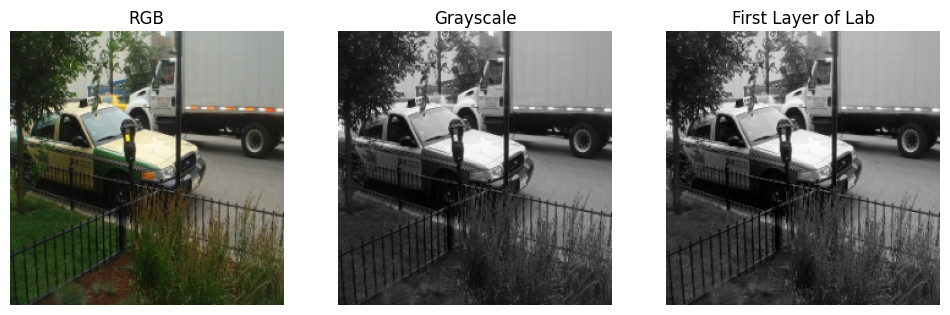

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(ti.get_rgb())
ax[0].set_title('RGB')
ax[1].imshow(ti.get_gray(), cmap='gray')
ax[1].set_title('Grayscale')
ax[2].imshow(ti.get_lab(True), cmap='gray')
ax[2].set_title('First Layer of Lab')

# clear x-axis and y-axis
ax[0].axis('off')
ax[1].axis('off') 
ax[2].axis('off')

plt.show()

## Define & Load Model

In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            
        )

    def forward(self, x):
        self.model = self.model.float()
        return self.model(x.float())
    
class FusionLayer(nn.Module):
    def __init__(self):
        super(FusionLayer,self).__init__()

    def forward(self, inputs, mask=None):
        ip, emb = inputs
        emb = torch.stack([torch.stack([emb],dim=2)],dim=3)
        emb = emb.repeat(1,1,ip.shape[2],ip.shape[3])
        fusion = torch.cat((ip,emb),1)
        return fusion
    
class Decoder(nn.Module):
    def __init__(self, input_depth):
        super(Decoder,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_depth, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),


            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),


            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=2, out_channels=2, kernel_size=1, stride=1, padding=0),     
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)
    
class Colorization(nn.Module):
    def __init__(self, depth_after_fusion):
        super(Colorization,self).__init__()
        self.encoder = Encoder()
        self.fusion = FusionLayer()
        self.after_fusion = nn.Conv2d(in_channels=1256, out_channels=depth_after_fusion,kernel_size=1, stride=1,padding=0)
        self.bnorm = nn.BatchNorm2d(256)
        self.decoder = Decoder(depth_after_fusion)

    def forward(self, img_l, img_emb):
        img_enc = self.encoder(img_l)
        # new_img_emb = torch.zeros_like(img_emb)
        fusion = self.fusion([img_enc, img_emb])
        fusion = self.after_fusion(fusion)
        fusion = self.bnorm(fusion)
        return self.decoder(fusion)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Colorization(256).to(device)

checkpoint = torch.load("Models/checkpoint18.pt", map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [59]:
inception_model = models.inception_v3(pretrained=True).float().to(device)
inception_model = inception_model.float()
inception_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [60]:
inception_img = ti.get_inception_img(direct_input=True)
img_embs = inception_model(inception_img.float())
output_ab = model(ti.get_encoder_img(direct_input=True), img_embs)

In [73]:
def concatente_and_colorize(im_lab, img_ab) -> np.ndarray:
    # Assumption is that im_lab is of size [1,1,224,224]
    print(im_lab.size(),img_ab.size())
    np_img = im_lab[0].cpu().detach().numpy().transpose(1,2,0)
    lab = np.empty([*np_img.shape[0:2], 3],dtype=np.float32)
    lab[:, :, 0] = np.squeeze(((np_img + 1) * 50))
    lab[:, :, 1:] = img_ab[0].cpu().detach().numpy().transpose(1,2,0) * 127
    np_img = cv2.cvtColor(lab,cv2.COLOR_Lab2RGB) 
    color_im = torch.stack([torchvision.transforms.ToTensor()(np_img)],dim=0)
    color_img_jpg = color_im[0].detach().numpy().transpose(1,2,0)
    return color_img_jpg


In [74]:
new_lab_image = torch.stack([ti.get_encoder_img(direct_input=True)[:,0,:,:]], dim=1)
color_img = concatente_and_colorize(new_lab_image, output_ab)

torch.Size([1, 1, 224, 224]) torch.Size([1, 2, 224, 224])


/Users/harshraod/miniconda3/envs/LearnPyTorch/lib/python3.8/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


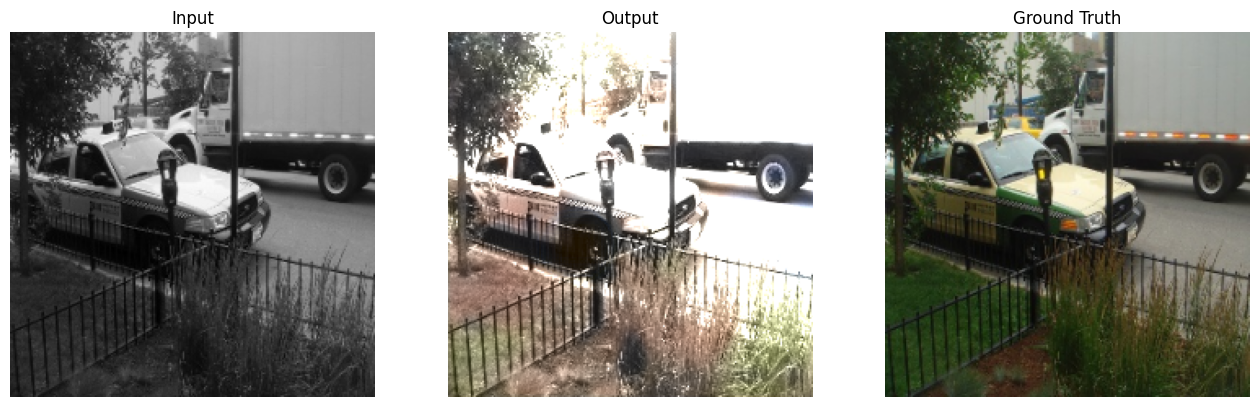

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

ax[0].imshow(ti.get_gray(), cmap='gray')
ax[0].set_title('Input')
ax[1].imshow(color_img)
ax[1].set_title('Output')
ax[2].imshow(ti.get_rgb())
ax[2].set_title('Ground Truth')

# clear x-axis and y-axis
ax[0].axis('off')
ax[1].axis('off') 
ax[2].axis('off')

plt.show()